In [9]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, pearsonr, ranksums, linregress
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import itertools
import statannot
from statsmodels.stats.multitest import fdrcorrection

from deeplift.visualization import viz_sequence


matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'


# HEPG2_COL = 'log2FoldChange_HepG2_DNA'
# K562_COL = 'log2FoldChange_K562_DNA'
HEPG2_COL = 'log2FoldChange_HepG2'
K562_COL = 'log2FoldChange_K562'
H2K_COL = 'log2FoldChange_H2K'

figure_dir = 'figures'

TITLE_FSIZE = 12
AXIS_FSIZE = 12
TEXT_FSIZE = 10

greysBig = matplotlib.cm.get_cmap('Greys', 512)
greys_trunc_cm = matplotlib.colors.ListedColormap(greysBig(np.linspace(0.6, 1, 256)))

bluesBig = matplotlib.cm.get_cmap('Blues', 512)
# blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.15, 0.8, 256)))
blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.25, 0.8, 256)))

orangesBig = matplotlib.cm.get_cmap('Oranges', 512)
# oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.15, 0.8, 256)))
oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.25, 0.8, 256)))

from fig_utils import plot_scatter_shaded, load_ensemble_model, load_model_for_shap, plot_seq_with_motifs, cluster_name_dict, seq_to_one_hot,round_palette

# import logging from matplotlib
import logging
logging.getLogger('matplotlib.font_manager').disabled = True


supp_fig_dir = 'figures/supp_figures'

fig2_dir = f'{figure_dir}/fig2'
os.makedirs(fig2_dir,exist_ok=True)

fig3_dir = f'{figure_dir}/fig3'
os.makedirs(fig3_dir,exist_ok=True)

C:\Users\Chris\AppData\Local\Temp\ipykernel_21796\3247803321.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greysBig = matplotlib.cm.get_cmap('Greys', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_21796\3247803321.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluesBig = matplotlib.cm.get_cmap('Blues', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_21796\3247803321.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orangesBig = matplotlib.cm.get_cmap('Orange

In [2]:
custom_color_vec = ["#FC440F","#5B5F97","#FFC145","#BBE1C3","#6C9A8B"]
custom_green_palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95)

round_palette = {
    'R0': sns.color_palette("Grays", 5)[2],
    'R1': custom_color_vec[3],
    'R2': custom_green_palette[3],
}

In [3]:
### Load D1, D2, and D3 data ###

# reverse complement function
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return ''.join(complement[base] for base in reversed(seq))

bc_deseqs_dir = 'bc_deseq_dfs/weighted/comb_dhs'

d2_deseq_df = pd.read_csv(f'{bc_deseqs_dir}/d2_deseq_df.csv')
d3_seq_df = pd.read_csv(f'{bc_deseqs_dir}/d3_seq_df.csv')
dhs_deseq_df = pd.read_csv(f'{bc_deseqs_dir}/dhs_deseq_df.csv')
dhs_train_df = pd.read_csv('fimo_fastas/dhs_train_seq_df_plus_cluster_counts_qthresh0.05.csv')
# rename Unnamed: 0 to index
dhs_train_df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

d1_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d1_deseq_plus_cluster_cnts_df.csv')
d2_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d2_deseq_plus_cluster_cnts_df.csv')
d3_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d3_deseq_plus_cluster_cnts_df.csv')

d1_deseq_plus_cluster_cnts_df['sequence_name'] = d1_deseq_plus_cluster_cnts_df.index
d1_deseq_plus_cluster_cnts_df['sequence_name'] = d1_deseq_plus_cluster_cnts_df['sequence_name'].apply(lambda x: f'd1_seq_{x}')

# for any seqs in d2_deseq_df with enhancer column matching a seq column in d1_deseq_plus_cluster_cnts_df, reassign sequence_name column in d2_deseq_df to corresponding column in d1_deseq_plus_cluster_cnts_df
for idx,row in d2_deseq_df.iterrows():
    cur_enhancer = row['enhancer']
    if cur_enhancer in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==cur_enhancer,'sequence_name'].values[0]
        d2_deseq_df.loc[idx,'sequence_name'] = d1_seq_name
        # also rename the row in d2_deseq_df where enhancer is the reverse_complement of this enhancer
        d2_deseq_df.loc[d2_deseq_df['enhancer']==reverse_complement(cur_enhancer),'sequence_name'] = f'{d1_seq_name}_rc'

d2_deseq_plus_cluster_cnts_df['sequence_name'] = d2_deseq_df['sequence_name']
# rename log2FoldChange_HEPG2 to HEPG2_COL in d2_deseq_plus_cluster_cnts_df
d2_deseq_plus_cluster_cnts_df.rename(columns={'log2FoldChange_HEPG2': HEPG2_COL}, inplace=True)

# for any seqs in d3_deseq_df with enhancer column matching a seq column in d1_deseq_plus_cluster_cnts_df, reassign sequence_name column in d3_deseq_df to corresponding column in d1_deseq_plus_cluster_cnts_df
for idx,row in d3_seq_df.iterrows():
    cur_enhancer = row['sequence']
    if cur_enhancer in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==cur_enhancer,'sequence_name'].values[0]
        d3_seq_df.loc[idx,'sequence_name'] = d1_seq_name
    elif reverse_complement(cur_enhancer) in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==reverse_complement(cur_enhancer),'sequence_name'].values[0]
        d3_seq_df.loc[d3_seq_df['sequence']==reverse_complement(cur_enhancer),'sequence_name'] = f'{d1_seq_name}_rc'

d3_deseq_plus_cluster_cnts_df['sequence_name'] = d3_seq_df['sequence_name']

d1_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d1_final_df_qthresh05_v2.csv')
d2_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d2_final_df_qthresh05_v2.csv')
d3_final_df = pd.read_csv('../designed_seqs/d3_tot_final_df_qthresh0.05.csv')

# get the max log2FoldChange_H2K_deseq for rows of analysis_df where model_type is control
h2k_ctrl_max = d3_seq_df.loc[d3_seq_df['model_type']=="d2_meas",H2K_COL].max()
# get the min log2FoldChange_H2K_deseq for rows of analysis_df where model_type is control
h2k_ctrl_min = d3_seq_df.loc[d3_seq_df['model_type']=="d2_meas",H2K_COL].min()

### Fig 3A: motif density ###

In [44]:
custom_color_vec = ["#FC440F","#5B5F97","#FFC145","#BBE1C3","#6C9A8B"]
custom_green_palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95)
round_palette = {
    'R0': sns.color_palette("Grays", 5)[2],
    'R0-D': sns.color_palette("Grays", 5)[1],
    'R1-D': custom_green_palette[1],
    'R1': custom_green_palette[2],
    'R2': custom_green_palette[3],
}

# round_palette = {
#     'R0': sns.color_palette("Grays", 5)[2],
#     'R0-D': '#b6ad90',
#     'R1-D':'#936639',
#     'R1': custom_green_palette[2],
#     'R2': custom_green_palette[3],
# }

In [ ]:
### plot motif density histograms ###

# plot number of motifs per unique sequence as a histogram, for both d1 and d2, using the bins 0,1,2,3,4,5,6,7 and same bin width

d3_model_types = ['d1_finetuned','d2_dhs']
d3_design_types = ['fsp','fsp_clipped']

# merge the two dataframes
d1_deseq_plus_cluster_cnts_df['dataset'] = 'R0'
d2_deseq_plus_cluster_cnts_df['dataset'] = 'R1'
d3_deseq_plus_cluster_cnts_df['dataset'] = 'R2'
dhs_deseq_df['dataset'] = 'R1-D'
dhs_train_df['dataset'] = 'R0-D'
d1_for_hist = d1_deseq_plus_cluster_cnts_df[['n_motifs','dataset']].copy()
# look only at de novo designed sequences
d2_for_hist = d2_deseq_plus_cluster_cnts_df[~d2_deseq_plus_cluster_cnts_df['design_type'].isin(['control','motif_repeat'])][['n_motifs','dataset']].copy()
d3_for_hist = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(d3_model_types)) & 
                                            (d3_deseq_plus_cluster_cnts_df['design_type'].isin(d3_design_types))][['n_motifs','dataset']].copy()

dhs_for_hist = dhs_deseq_df[['n_motifs','dataset']].copy()
dhs_train_for_hist = dhs_train_df[['n_motifs','dataset']]

df_for_hist = pd.concat((d1_for_hist,dhs_train_for_hist,dhs_for_hist,d2_for_hist,d3_for_hist))

C:\Users\Chris\AppData\Local\Temp\ipykernel_15604\4150149919.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_for_hist,x='dataset',y='n_motifs',order=order,palette=round_palette,notch=True,fliersize=1,linewidth=1.5)


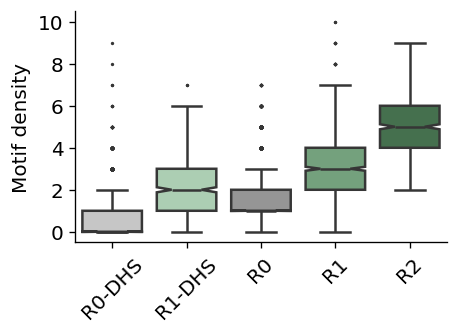

In [61]:
# boxplots of motif density
plt.figure(figsize=(4,2.5))
order = ['R0-D','R1-D','R0','R1','R2']
sns.boxplot(data=df_for_hist,x='dataset',y='n_motifs',order=order,palette=round_palette,notch=True,fliersize=1,linewidth=1.5)
# sns.violinplot(data=df_for_hist,x='dataset',y='n_motifs',order=order,palette=round_palette)
plt.xlabel('',fontsize=AXIS_FSIZE)
plt.ylabel('Motif density',fontsize=AXIS_FSIZE)
xticks = ['R0-DHS','R1-DHS','R0','R1','R2']
plt.xticks(ticks=range(5),labels=xticks,fontsize=12,rotation=45)
plt.title('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()

# plt.savefig(f'{fig2_dir}/motif_density_with_dhs.png',dpi=500,bbox_inches='tight')

In [18]:
d1_analysis_df = d1_deseq_plus_cluster_cnts_df.copy()
d2_analysis_df = d2_deseq_plus_cluster_cnts_df[~d2_deseq_plus_cluster_cnts_df['design_type'].isin(['control','motif_repeat'])].copy()
d3_analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(d3_model_types)) & 
                                               (d3_deseq_plus_cluster_cnts_df['design_type'].isin(d3_design_types))].copy()
dhs_analysis_df = dhs_deseq_df[dhs_deseq_df['design_type']=='gan'].copy()

n_motifs_d1 = d1_analysis_df['n_motifs'].sum()
n_motifs_d2 = d2_analysis_df['n_motifs'].sum()
n_motifs_d3 = d3_analysis_df['n_motifs'].sum()
n_motifs_dhs = dhs_analysis_df['n_motifs'].sum()
n_motifs_dhs_train = dhs_train_df['n_motifs'].sum()

n_d1_seqs = d1_analysis_df.shape[0]
n_d2_seqs = d2_analysis_df.shape[0]
n_d3_seqs = d3_analysis_df.shape[0]
n_dhs_seqs = dhs_analysis_df.shape[0]
n_dhs_train_seqs = dhs_train_df.shape[0]

d1_clusters = [col for col in d1_analysis_df.columns if 'cluster_' in col]
n_unique_clusters_d1 = np.sum(d1_analysis_df[d1_clusters].astype(bool).sum(axis=0) > 0)

d2_clusters = [col for col in d2_analysis_df.columns if 'cluster_' in col]
n_unique_clusters_d2 = np.sum(d2_analysis_df[d2_clusters].astype(bool).sum(axis=0) > 0)

d3_cluster_cols = [col for col in d3_analysis_df.columns if 'cluster_' in col]
n_unique_clusters_d3 = np.sum(d3_analysis_df[d3_cluster_cols].astype(bool).sum(axis=0) > 0) # get number of cluster_cols with non-zero values

dhs_cluster_cols = [col for col in dhs_analysis_df.columns if 'cluster_' in col]
n_unique_clusters_dhs = np.sum(dhs_analysis_df[dhs_cluster_cols].astype(bool).sum(axis=0) > 0)

dhs_train_cluster_cols = [col for col in dhs_train_df.columns if 'cluster_' in col]
n_unique_clusters_dhs_train = np.sum(dhs_train_df[dhs_train_cluster_cols].astype(bool).sum(axis=0) > 0)

median_d1 = d1_analysis_df['n_motifs'].median()
median_d2 = d2_analysis_df['n_motifs'].median()
median_d3 = d3_analysis_df['n_motifs'].median()
median_dhs = dhs_analysis_df['n_motifs'].median()
median_dhs_train = dhs_train_df['n_motifs'].median()

print(f'D1: {n_motifs_d1}/{n_d1_seqs}={n_motifs_d1/n_d1_seqs:.2f} motifs/seq, {n_unique_clusters_d1} unique clusters')
print(f'D2: {n_motifs_d2}/{n_d2_seqs}={n_motifs_d2/n_d2_seqs:.2f} motifs/seq, {n_unique_clusters_d2} unique clusters')
print(f'D3: {n_motifs_d3}/{n_d3_seqs}={n_motifs_d3/n_d3_seqs:.2f} motifs/seq, {n_unique_clusters_d3} unique clusters')
print(f'DHS: {n_motifs_dhs}/{n_dhs_seqs}={n_motifs_dhs/n_dhs_seqs:.2f} motifs/seq, {n_unique_clusters_dhs} unique clusters')
print(f'DHS Train: {n_motifs_dhs_train}/{n_dhs_train_seqs}={n_motifs_dhs_train/n_dhs_train_seqs:.2f} motifs/seq, {n_unique_clusters_dhs_train} unique clusters')

print(f'D1 median: {median_d1}')
print(f'D2 median: {median_d2}')
print(f'D3 median: {median_d3}')
print(f'DHS median: {median_dhs}')
print(f'DHS Train median: {median_dhs_train}')

D1: 46842/29891=1.57 motifs/seq, 67 unique clusters
D2: 3580/1084=3.30 motifs/seq, 41 unique clusters
D3: 3330/688=4.84 motifs/seq, 29 unique clusters
DHS: 1458/600=2.43 motifs/seq, 50 unique clusters
DHS Train: 17797/35984=0.49 motifs/seq, 48 unique clusters
D1 median: 1.0
D2 median: 3.0
D3 median: 5.0
DHS median: 2.0
DHS Train median: 0.0


In [20]:
dhs_analysis_df['cluster_50'].sum()

1.0

### Fig 3B: log2(H2K) vs motif density ###

Evaluting motif density relationship with log2FoldChange_H2K for HEPG2-targeted designs...
	log2FoldChange_H2K slope: 0.176
	log2FoldChange_H2K p_value: 1.90e-03
	log2FoldChange_H2K Bonferroni adjusted p_value: 3.79e-03
	95% confidence interval: 0.066 to 0.286


C:\Users\Chris\AppData\Local\Temp\ipykernel_21796\1537372614.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2','3','4','5','6','7+'],fontsize=AXIS_FSIZE)


Evaluting motif density relationship with log2FoldChange_H2K for K562-targeted designs...
	log2FoldChange_H2K slope: -0.266
	log2FoldChange_H2K p_value: 4.43e-07
	log2FoldChange_H2K Bonferroni adjusted p_value: 8.87e-07
	95% confidence interval: -0.367 to -0.164


C:\Users\Chris\AppData\Local\Temp\ipykernel_21796\1537372614.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2','3','4','5','6','7+'],fontsize=AXIS_FSIZE)


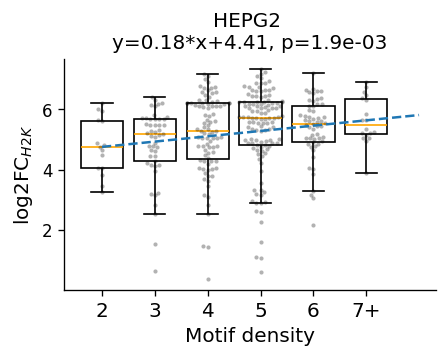

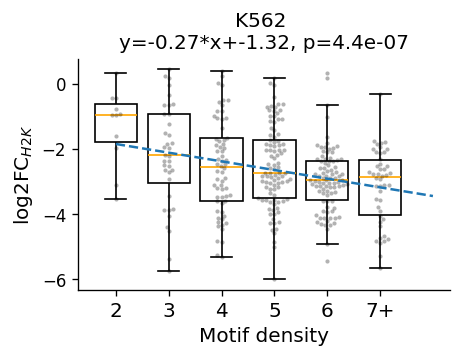

In [10]:
d3_model_types = ['d1_finetuned','d2_dhs']
d3_design_types = ['fsp','fsp_clipped']

analysis_df = d3_deseq_plus_cluster_cnts_df[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(d3_model_types)) & 
                                            (d3_deseq_plus_cluster_cnts_df['design_type'].isin(d3_design_types))].copy()

analysis_df['n_motifs_for_plot'] = analysis_df['n_motifs'].astype(int)
analysis_df.loc[analysis_df['n_motifs_for_plot']>=7,'n_motifs_for_plot'] = 7
analysis_df['n_motifs_txt'] = analysis_df['n_motifs_for_plot'].astype(str)
analysis_df.loc[analysis_df['n_motifs_txt']=='7','n_motifs_txt'] = '7+'

analysis_df['abs_log2FoldChange_H2K'] = analysis_df[H2K_COL].abs()

# score_cols = [HEPG2_COL,K562_COL,H2K_COL,H2K_COL,'abs_log2FoldChange_H2K']
# cell_types = ['HEPG2','K562','HEPG2','K562','both HEPG2 & K562']
score_cols = [H2K_COL,H2K_COL]
cell_types = ['HEPG2','K562']

n_tests = len(score_cols)

for score_col,cell_type in zip(score_cols,cell_types):
    print(f'Evaluting motif density relationship with {score_col} for {cell_type}-targeted designs...')

    if score_col == 'abs_log2FoldChange_H2K':
        cur_analysis_df = analysis_df.copy()
    else:
        cur_analysis_df = analysis_df[analysis_df['cell_type']==cell_type].copy()

    # if score_col == HEPG2_COL:
    #     cur_analysis_df = analysis_df[analysis_df['cell_type']=='HEPG2'].copy()
    # elif score_col == K562_COL:
    #     cur_analysis_df = analysis_df[analysis_df['cell_type']=='K562'].copy()
    # elif score_col == 'abs_log2FoldChange_H2K':
    #     cur_analysis_df = analysis_df.copy()
    # else:
    #     cur_analysis_df = analysis_df[analysis_df['cell_type']=='HEPG2'].copy()

    # use statannot to make boxplot of abs_log2FoldChange_H2K vs n_motifs_for_plot, using ranksums test to calculate p-values and plot significance
    fig,ax = plt.subplots(figsize=(4,2.5))
    # sns.swarmplot(x=cur_analysis_df['n_motifs_txt'],y=cur_analysis_df[score_col],ax=ax,
    #               color='k',size=2.5,alpha=0.3,order=['2','3','4','5','6','7+'])
    # sns.boxplot(x='n_motifs_txt',y=score_col,data=cur_analysis_df,fliersize=1,ax=ax,
    #             boxprops={'edgecolor':'k','facecolor':'white'},
    #             medianprops={'color':'orange'},whiskerprops={'color':'k'},capprops={'color':'k'},
    #             order=['2','3','4','5','6','7+'])
    sns.swarmplot(x=cur_analysis_df['n_motifs_for_plot'],y=cur_analysis_df[score_col],ax=ax,
                color='k',size=2.5,alpha=0.3)
    sns.boxplot(x='n_motifs_for_plot',y=score_col,data=cur_analysis_df,fliersize=1,ax=ax,
                boxprops={'edgecolor':'k','facecolor':'white'},showfliers=False,
                medianprops={'color':'orange'},whiskerprops={'color':'k'},capprops={'color':'k'},)
    
    # statannot.add_stat_annotation(x='n_motifs_for_plot',y=score_col,data=cur_analysis_df,ax=ax,
    #                             box_pairs=[(2,3),(3,4),(4,5),(5,6),(6,7)],
    #                             test='Mann-Whitney',text_format='star',loc='outside',verbose=2,comparisons_correction='bonferroni')
    
    
    # positions = cur_analysis_df['target'].value_counts().sort_index().index
    # sns.boxplot(x=cur_analysis_df['target'].astype(float),y=cur_analysis_df[H2K_COL],ax=ax[cell_idx],showfliers=False,boxprops={'color':'k','facecolor':'white'},
    #             medianprops={'color':'orange'},whiskerprops={'color':'k'},capprops={'color':'k'},width=0.6,zorder=20)

    # nothing is significant
    # statannot.add_stat_annotation(x='n_motifs_txt',y='abs_log2FoldChange_H2K',data=analysis_df,ax=ax,order=['2','3','4','5','6','7','8+'],
    #                               box_pairs=[('2','3'),('3','4'),('4','5'),('5','6'),('6','7'),('7','8+')],
    #                               test='Mann-Whitney',text_format='star',loc='outside',verbose=2,comparisons_correction='bonferroni')
    plt.xlabel('Motif density',fontsize=AXIS_FSIZE)
    plt.ylabel('log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
    # set xtick labels to n_motifs_txt
    ax.set_xticklabels(['2','3','4','5','6','7+'],fontsize=AXIS_FSIZE)
    # plt.title(f'{score_col}',fontsize=TITLE_FSIZE)
    # remove spines
    sns.despine()

    # # add line of best fit
    slope, intercept, r_value, p_value, std_err = linregress(cur_analysis_df['n_motifs_for_plot'],cur_analysis_df[score_col])
    x = np.arange(2,9)
    y = slope*x + intercept
    plt.plot(x-2,y,linestyle='--',color='tab:blue',linewidth=1.5,zorder=20)

    # add title with slope and p-value
    plt.title(f'{cell_type} \ny={slope:.2f}*x+{intercept:.2f}, p={p_value:.1e}',fontsize=TITLE_FSIZE)


    # calculate linear regression slope and significance
    # slope, intercept, r_value, p_value, std_err = linregress(cur_analysis_df['n_motifs_for_plot'],cur_analysis_df[score_col])
    print(f'\t{score_col} slope: {slope:.3f}')
    print(f'\t{score_col} p_value: {p_value:.2e}')
    print(f'\t{score_col} Bonferroni adjusted p_value: {p_value*n_tests:.2e}')
    print(f'\t95% confidence interval: {slope - 1.96*std_err:.3f} to {slope + 1.96*std_err:.3f}')
    # # calculate linear regression slope and significance for log2FoldChange(HEPG2)
    # slope, intercept, r_value, p_value, std_err = linregress(analysis_df['n_motifs_for_plot'],analysis_df[HEPG2_COL])
    # print(f'HEPG2 slope: {slope:.3f}')
    # print(f'HEPG2 p_value: {p_value:.2e}')
    # # calculate linear regression slope and significance for log2FoldChange(K562)
    # slope, intercept, r_value, p_value, std_err = linregress(analysis_df['n_motifs_for_plot'],analysis_df[K562_COL])
    # print(f'K562 slope: {slope:.3f}')
    # print(f'K562 p_value: {p_value:.2e}')

    # save figure at 500 dpi
    plt.savefig(f'{fig3_dir}/fig3_motif_density_H2K_{cell_type}.png',dpi=600,bbox_inches='tight',transparent=True)

In [15]:
analysis_df['n_motifs_for_plot'].value_counts().sort_index()

n_motifs_for_plot
0     27
1    124
2    216
3    229
4    181
5    141
6     83
7     36
Name: count, dtype: int64

### Fig 3E: Comparing motif enrichment across libraries ###

In [5]:
round_palette = {
    'R0': sns.color_palette("Grays", 5)[2],
    'R0-D': '#a68a64',
    'R1-D':'#7f4f24',
    'R1': custom_green_palette[2],
    'R2': custom_green_palette[3],
}

In [ ]:
# vertical version - now wit the DHS data included!

n_top_motifs_per_dataset = 7

motif_dir = '../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning'
jaspar_cluster_df = pd.read_csv(f'{motif_dir}/jaspar_motif_clusters.tsv',sep='\t',header=None,names=['cluster','motifs'])
jaspar_cluster_df['motifs'] = jaspar_cluster_df['motifs'].apply(lambda x: x.upper())

d1_analysis_seqs = d1_final_df['sequence_name'].unique()
d2_analysis_seqs = d2_deseq_df[~d2_deseq_df['generator'].isin(['control','motif_repeat'])].index
d3_model_types = ['d1_finetuned','d2_dhs']
d3_design_types = ['fsp','fsp_clipped']
d3_analysis_seqs = d3_seq_df[(d3_seq_df['model_type'].isin(d3_model_types))&(d3_seq_df['design_type'].isin(d3_design_types))]['sequence_name'].values

d1_final_df_filt = d1_final_df[d1_final_df['sequence_name'].isin(d1_analysis_seqs)].copy()
d2_final_df_filt = d2_final_df[d2_final_df['sequence_name'].isin(d2_analysis_seqs)].copy()
d3_final_df_filt = d3_final_df[d3_final_df['sequence_name'].isin(d3_analysis_seqs)].copy()

dhs_train_final_df_filt = pd.read_csv('fimo_fastas/dhs_classifier_training_final_df_qthresh0.05.csv')
dhs_design_final_df_filt = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/dw_final_df_qthresh05_v2.csv')

###
d1_motif_cluster_df = pd.DataFrame(columns=['motif_alt_id','jaspar_cluster'])
for motif in d1_final_df_filt['motif_alt_id'].unique():
    jaspar_cluster_id = jaspar_cluster_df[jaspar_cluster_df['motifs'].str.contains(motif)]['cluster'].values[0]
    d1_motif_cluster_df = pd.concat([d1_motif_cluster_df, pd.DataFrame({'motif_alt_id':[motif], 'jaspar_cluster':[jaspar_cluster_id]})])

# create a dataframe with the motif names in final_df['motif_alt_id'].unique() and the cluster they belong to in jaspar_cluster_df
d2_motif_cluster_df = pd.DataFrame(columns=['motif_alt_id','jaspar_cluster'])
for motif in d2_final_df_filt['motif_alt_id'].unique():
    jaspar_cluster_id = jaspar_cluster_df[jaspar_cluster_df['motifs'].str.contains(motif)]['cluster'].values[0]
    d2_motif_cluster_df = pd.concat([d2_motif_cluster_df, pd.DataFrame({'motif_alt_id':[motif], 'jaspar_cluster':[jaspar_cluster_id]})])

d3_motif_cluster_df = pd.DataFrame(columns=['motif_alt_id','jaspar_cluster'])
for motif in d3_final_df_filt['motif_alt_id'].unique():
    jaspar_cluster_id = jaspar_cluster_df[jaspar_cluster_df['motifs'].str.contains(motif)]['cluster'].values[0]
    d3_motif_cluster_df = pd.concat([d3_motif_cluster_df, pd.DataFrame({'motif_alt_id':[motif], 'jaspar_cluster':[jaspar_cluster_id]})])

dhs_design_cluster_df = pd.DataFrame(columns=['motif_alt_id','jaspar_cluster'])
for motif in dhs_design_final_df_filt['motif_alt_id'].unique():
    jaspar_cluster_id = jaspar_cluster_df[jaspar_cluster_df['motifs'].str.contains(motif)]['cluster'].values[0]
    dhs_design_cluster_df = pd.concat([dhs_design_cluster_df, pd.DataFrame({'motif_alt_id':[motif], 'jaspar_cluster':[jaspar_cluster_id]})])

dhs_train_cluster_df = pd.DataFrame(columns=['motif_alt_id','jaspar_cluster'])
for motif in dhs_train_final_df_filt['motif_alt_id'].unique():
    jaspar_cluster_id = jaspar_cluster_df[jaspar_cluster_df['motifs'].str.contains(motif)]['cluster'].values[0]
    dhs_train_cluster_df = pd.concat([dhs_train_cluster_df, pd.DataFrame({'motif_alt_id':[motif], 'jaspar_cluster':[jaspar_cluster_id]})])

d1_clusters = d1_motif_cluster_df['jaspar_cluster'].unique()
d2_clusters = d2_motif_cluster_df['jaspar_cluster'].unique()
d3_clusters = d3_motif_cluster_df['jaspar_cluster'].unique()
dhs_train_clusters = dhs_train_cluster_df['jaspar_cluster'].unique()
dhs_design_clusters = dhs_design_cluster_df['jaspar_cluster'].unique()

print(f'Number of clusters in D1: {len(d1_clusters)}')
print(f'Number of clusters in D2: {len(d2_clusters)}')
print(f'Number of clusters in D3: {len(d3_clusters)}')
print(f'Number of clusters in DHS Train: {len(dhs_train_clusters)}')
print(f'Number of clusters in DHS Design: {len(dhs_design_clusters)}')


# okay, get the 10 most frequent motifs in D1 and the ten most frequent motifs in D2

# d1_motif_freq = d1_final_df_filt['jaspar_cluster'].value_counts() / d1_final_df_filt['jaspar_cluster'].value_counts().sum()
# d2_motif_freq = d2_final_df_filt['jaspar_cluster'].value_counts() / d2_final_df_filt['jaspar_cluster'].value_counts().sum()
# d3_motif_freq = d3_final_df_filt['jaspar_cluster'].value_counts() / d3_final_df_filt['jaspar_cluster'].value_counts().sum()
# redefine frequency metric as n_motifs/n_seqs
d1_motif_freq = d1_final_df_filt['jaspar_cluster'].value_counts() / len(d1_analysis_seqs)
d2_motif_freq = d2_final_df_filt['jaspar_cluster'].value_counts() / len(d2_analysis_seqs)
d3_motif_freq = d3_final_df_filt['jaspar_cluster'].value_counts() / len(d3_analysis_seqs)
dhs_train_motif_freq = dhs_train_final_df_filt['jaspar_cluster'].value_counts() / len(dhs_train_final_df_filt)
dhs_design_motif_freq = dhs_design_final_df_filt['jaspar_cluster'].value_counts() / len(dhs_design_final_df_filt)

# get the names of the 10 most frequent motifs in D1
d1_top_motifs = d1_motif_freq.index[:n_top_motifs_per_dataset]
# get the names of the 10 most frequent motifs in D2
d2_top_motifs = d2_motif_freq.index[:n_top_motifs_per_dataset]
# get the names of the 10 most frequent motifs in D3
d3_top_motifs = d3_motif_freq.index[:n_top_motifs_per_dataset]
# get the names of the 10 most frequent motifs in DHS Train
dhs_train_top_motifs = dhs_train_motif_freq.index[:n_top_motifs_per_dataset-3]
# get the names of the 10 most frequent motifs in DHS Design
dhs_design_top_motifs = dhs_design_motif_freq.index[:n_top_motifs_per_dataset-3]

# get union of d1_top_motifs and d2_top_motifs
d1_d2_union_motifs = np.union1d(d1_top_motifs, d2_top_motifs)
d1_d2_d3_union_motifs = np.union1d(d1_d2_union_motifs, d3_top_motifs)
d1_d2_d3_union_motifs = np.union1d(d1_d2_d3_union_motifs,dhs_train_top_motifs)
d1_d2_d3_union_motifs = np.union1d(d1_d2_d3_union_motifs,dhs_design_top_motifs)

# get the number of unique motifs in the union
d1_d2_d3_union_motifs.shape

d1_top_freq_vec = np.zeros(d1_d2_d3_union_motifs.shape)
d2_top_freq_vec = np.zeros(d1_d2_d3_union_motifs.shape)
d3_top_freq_vec = np.zeros(d1_d2_d3_union_motifs.shape)
dhs_train_top_freq_vec = np.zeros(d1_d2_d3_union_motifs.shape)
dhs_design_top_freq_vec = np.zeros(d1_d2_d3_union_motifs.shape)

for motif_idx, motif in enumerate(d1_d2_d3_union_motifs):
    if motif in d3_motif_freq.index:
        d3_top_freq_vec[motif_idx] = d3_motif_freq[motif]
    if motif in d2_motif_freq.index:
        d2_top_freq_vec[motif_idx] = d2_motif_freq[motif]
    if motif in d1_motif_freq.index:
        d1_top_freq_vec[motif_idx] = d1_motif_freq[motif]
    if motif in dhs_train_motif_freq.index:
        dhs_train_top_freq_vec[motif_idx] = dhs_train_motif_freq[motif]
    if motif in dhs_design_motif_freq.index:
        dhs_design_top_freq_vec[motif_idx] = dhs_design_motif_freq[motif]

    # if motif in d3_top_motifs:
    #     d3_top_freq_vec[motif_idx] = d3_motif_freq[motif]
    # if motif in d2_top_motifs:
    #     d2_top_freq_vec[motif_idx] = d2_motif_freq[motif]
    # if motif in d1_top_motifs:
    #     d1_top_freq_vec[motif_idx] = d1_motif_freq[motif]
    # if motif in dhs_train_top_motifs:
    #     dhs_train_top_freq_vec[motif_idx] = dhs_train_motif_freq[motif]
    # if motif in dhs_design_top_motifs:
    #     dhs_design_top_freq_vec[motif_idx] = dhs_design_motif_freq[motif]

# get descending sort inds for d3_top_freq_vec
# temp setting this to be d1 instead of d3
d3_top_freq_vec_sort_inds = np.argsort(d1_top_freq_vec)#[::-1]
# d3_top_freq_vec_sort_inds[:6] = d3_top_freq_vec_sort_inds[[0,4,5,1,2,3]]

# replace _ with ' ' in d1_d2_d3_union_motifs_for_labels
# d1_d2_d3_union_motifs_for_labels = np.array([motif.replace('_',' ') for motif in d2_d3_union_motifs])
d1_d2_d3_union_motifs_for_labels = [cluster_name_dict[motif] for motif in d1_d2_d3_union_motifs]
d1_d2_d3_top_freq_vec = np.concatenate((d1_top_freq_vec,d2_top_freq_vec,d3_top_freq_vec,dhs_train_top_freq_vec,dhs_design_top_freq_vec))
# dataset_indicator_col = np.concatenate((np.zeros(d1_top_freq_vec.shape),np.ones(d2_top_freq_vec.shape),np.ones(d3_top_freq_vec.shape)*2))
dataset_indicator_col = ['R0']*d1_top_freq_vec.shape[0] + ['R1']*d2_top_freq_vec.shape[0] + ['R2']*d3_top_freq_vec.shape[0] + \
                        ['R0-D']*dhs_train_top_freq_vec.shape[0] + ['R1-D']*dhs_design_top_freq_vec.shape[0]

d1_d2_d3_top_freq_df = pd.DataFrame({'motif':d1_d2_d3_union_motifs_for_labels*5,
                                     'frequency':d1_d2_d3_top_freq_vec,
                                     'dataset':dataset_indicator_col})

# palette = {
#     'R0': 'tab:gray',
#     'R1': sns.color_palette("Set2")[0],
#     'R2': sns.color_palette("Set2")[1]
# }

motif_order = ['SP/KLF','CTCF','NFE2/JUNB','ZNF320','SPIB/ELK1',
               'HNF4A/NR2F1','HNF1A','GATA1::TAL1','GATA2/GATA5','HNF4A/HNF4G','TP53']

hue_order = ['R0-D','R1-D','R0','R1','R2']


In [29]:
cluster_freq_df

dataset,R0-D,R1-D,R0,R1,R2
motif,,,,,
NFE2/JUNB,0.000000,0.000000,0.202821,0.414207,0.921512
TP53,0.000000,0.000000,0.000000,0.656827,0.825581
HNF4A/HNF4G,0.052874,0.136306,0.000000,0.000000,0.610465
SPIB/ELK1,0.000000,0.092994,0.084783,0.342251,0.561047
GATA2/GATA5,0.000000,0.073248,0.000000,0.150369,0.482558
GATA1::TAL1,0.070574,0.000000,0.000000,0.000000,0.441860
HNF1A,0.000000,0.000000,0.000000,0.000000,0.306686
CTCF,0.000000,0.000000,0.254509,0.000000,0.000000
ZNF384,0.134236,0.000000,0.000000,0.000000,0.000000


C:\Users\Chris\AppData\Local\Temp\ipykernel_7676\810901821.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greysBig = matplotlib.cm.get_cmap('Greys', 512)


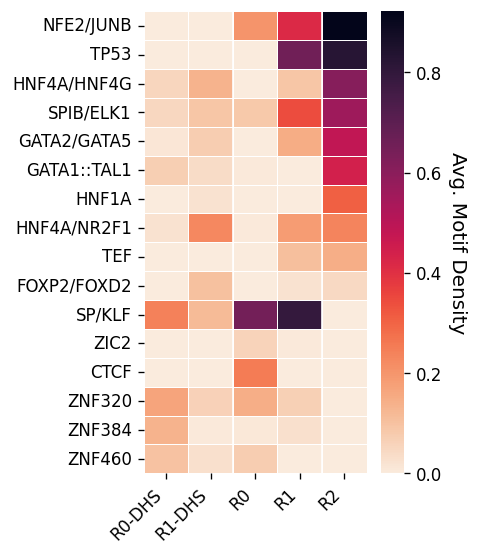

In [51]:
# finally, let's do a heatmap version

cluster_freq_df = d1_d2_d3_top_freq_df.pivot(index='motif',columns='dataset',values='frequency')
# sort by d1 frequency, descending
cluster_freq_df.sort_values(by='R2',ascending=False,inplace=True)

# change column order of cluster_freq_df to ['R0','R0-D','R1-D','R1','R2']
cluster_freq_df = cluster_freq_df[['R0-D','R1-D','R0','R1','R2']]
# # divide each cluster count by number of sequences with that enhancer_len
# for enhancer_len in cluster_freq_df['enhancer_len'].unique():
#     cluster_freq_df.loc[cluster_freq_df['enhancer_len']==enhancer_len,cluster_cols] = cluster_freq_df.loc[cluster_freq_df['enhancer_len']==enhancer_len,cluster_cols] / cur_analysis_df.loc[cur_analysis_df['enhancer_len']==enhancer_len].shape[0]

# dropp all clusters where the max frequency across all enhancer_lens is less than 0.1
# freq_thresh = 0.05
# cluster_freq_df.drop(columns=[col for col in cluster_cols if cluster_freq_df[col].max() < freq_thresh], inplace=True)
# cluster_cols = [col for col in cluster_freq_df.columns if 'cluster_' in col]
# n_cluster_vec += [len(cluster_cols)]


# cur_cluster_freq_df_T.sort_values(by=145,ascending=(cell_type=='K562'),inplace=True)

# cluster_freq_df_T = cluster_freq_df.set_index('enhancer_len').transpose()
# # rename enhancer_len column to cluster
# cluster_freq_df_T.index.name = 'cluster'

greysBig = matplotlib.cm.get_cmap('Greys', 512)
greys_freq_cm = matplotlib.colors.ListedColormap(greysBig(np.linspace(0.15, 0.9, 256)))
# get a reversed version of the colormap
greys_freq_cm_r = matplotlib.colors.ListedColormap(greysBig(np.linspace(0.9, 0.15, 256)))

# order=['R0','R0-D','R1-D','R1','R2']

# plot heatmap
plt.figure(figsize=(3,5))
sns.heatmap(cluster_freq_df,cmap='rocket_r',edgecolor='white',linewidth=0.5,annot=False,fmt='.2f')
plt.xlabel('',fontsize=AXIS_FSIZE)
plt.ylabel('',fontsize=AXIS_FSIZE)
plt.title(f'',fontsize=TITLE_FSIZE)
xticks = ['R0-DHS','R1-DHS','R0','R1','R2']
plt.xticks(ticks=np.arange(0.5,5.5),labels=xticks,fontsize=TEXT_FSIZE,rotation=45,ha='right')
# plt.xticks(fontsize=TEXT_FSIZE)
plt.yticks(fontsize=TEXT_FSIZE)
# set xticklabels to cluster_name_dict[cluster]
# ytick_labels = [tick.get_text() for tick in plt.yticks()[1]]
# yticks = plt.yticks()[0]
# plt.yticks(ticks=yticks,labels=[cluster_name_dict[cluster] for cluster in ytick_labels])

# label colorbar 'Frequency'
cbar = plt.gcf().axes[-1]
cbar.set_ylabel('Avg. Motif Density',fontsize=AXIS_FSIZE,rotation=270,labelpad=15)

# add a vertical white line after R1-DHS, R1
plt.axvline(2,color='white',linewidth=1)
plt.axvline(4,color='white',linewidth=1)

# draw an orange rectangle around the HEPG2 clusters
# plt.axhspan(0,n_cluster_vec[0],facecolor='none',edgecolor='tab:orange',linewidth=1.5)
# # draw a blue rectangle around the K562 clusters
# plt.axhspan(n_cluster_vec[0],n_cluster_vec[0]+n_cluster_vec[1],facecolor='none',edgecolor='tab:blue',linewidth=1.5)
# save figure at 600 dpi
plt.savefig(f'{fig2_dir}/fig2_motif_enrichment_across_rounds_heatmap.png',dpi=500,bbox_inches='tight')

### Fig 3F: Cell type-specific motif enrichment ###

In [23]:
d3_seq_df[d3_seq_df['model_type'].isin(d3_model_types)]['design_type'].value_counts()

design_type
fsp                             468
fsp_clipped                     220
d2_rand_ctrl                    198
fsp_tgt                         160
motif_flank_opt                 128
fsp_minimal                     110
nonmotif_masked_fsp             100
fsp_minimal_concatemer           60
fsp_max1                         20
fsp_min1                         20
fsp_clipped_max1                 20
fsp_clipped_min1                 19
fsp_minimal_cross_concatemer     13
d2_top_ctrl                      10
concatemer                        5
Name: count, dtype: int64

Number of clusters in top HEPG2: 22
Number of clusters in top K562: 13
Number of clusters in the top hepg2 and k562 seqs: 27


C:\Users\Chris\AppData\Local\Temp\ipykernel_28876\733803925.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hepg2_motif_freq = hepg2_motif_freq[hepg2_motif_freq_sort_inds]
C:\Users\Chris\AppData\Local\Temp\ipykernel_28876\733803925.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  k562_motif_freq = k562_motif_freq[k562_motif_freq_sort_inds]


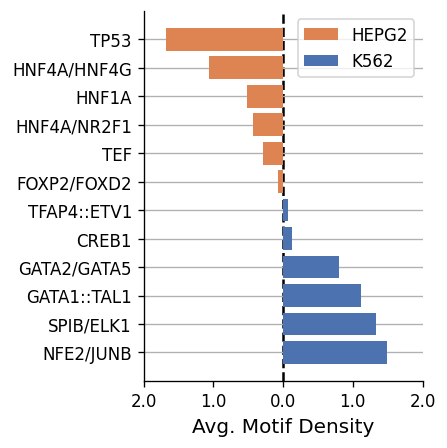

In [18]:
d3_model_types = ['d1_finetuned','d2_dhs','d2_meas'] # exclude the shuffled nonmotif since this will be a bunch of copies of the same motif set for the most part
# by that token I probably also want to exclude the nonmotif optimized sequences..? eh maybe since that will vary
d3_design_types = ['fsp','fsp_clipped','fsp_tgt','d2_rand_ctrl','d2_top_ctrl']
d3_analysis_seqs = d3_seq_df[(d3_seq_df['model_type'].isin(d3_model_types))&(d3_seq_df['design_type'].isin(d3_design_types))]['sequence_name'].values

analysis_df = d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['sequence_name'].isin(d3_analysis_seqs)].copy()


h2k_thresh = 3
k2h_thresh = -3


filt_df_hepg2 = analysis_df[(analysis_df[H2K_COL] > h2k_thresh)].copy()
filt_df_k562  = analysis_df[(analysis_df[H2K_COL] < k2h_thresh)].copy()


hepg2_clusters = d3_final_df[d3_final_df['sequence_name'].isin(filt_df_hepg2['sequence_name'].values)]['jaspar_cluster'].unique()
k562_clusters = d3_final_df[d3_final_df['sequence_name'].isin(filt_df_k562['sequence_name'].values)]['jaspar_cluster'].unique()

print(f'Number of clusters in top HEPG2: {len(hepg2_clusters)}')
print(f'Number of clusters in top K562: {len(k562_clusters)}')

union_clusters = np.union1d(hepg2_clusters, k562_clusters)
n_unique_clusters = len(union_clusters)
print(f'Number of clusters in the top hepg2 and k562 seqs: {n_unique_clusters}')


hepg2_motif_freq = filt_df_hepg2[hepg2_clusters].sum(axis=0) / filt_df_hepg2.shape[0]
k562_motif_freq = filt_df_k562[k562_clusters].sum(axis=0) / filt_df_k562.shape[0]

# sort by hepg2_motif_freq
hepg2_motif_freq_sort_inds = np.argsort(hepg2_motif_freq)[::-1]
hepg2_motif_freq = hepg2_motif_freq[hepg2_motif_freq_sort_inds]
hepg2_clusters = hepg2_clusters[hepg2_motif_freq_sort_inds]

# sort by k562_motif_freq
k562_motif_freq_sort_inds = np.argsort(k562_motif_freq)[::-1]
k562_motif_freq = k562_motif_freq[k562_motif_freq_sort_inds]
k562_clusters = k562_clusters[k562_motif_freq_sort_inds]

n_top_motifs_per_dataset = 6
# get the names of the 10 most frequent motifs in D1
hepg2_top_motifs = hepg2_motif_freq.index[:n_top_motifs_per_dataset]
# get the names of the 10 most frequent motifs in D2
k562_top_motifs = k562_motif_freq.index[:n_top_motifs_per_dataset]

# get union of hepg2_top_motifs and k562_top_motifs
top_union_motifs = np.union1d(hepg2_top_motifs, k562_top_motifs)

hepg2_top_freq_vec = np.zeros(top_union_motifs.shape)
k562_top_freq_vec = np.zeros(top_union_motifs.shape)

for motif_idx, motif in enumerate(top_union_motifs):
    if motif in k562_top_motifs:
        k562_top_freq_vec[motif_idx] = k562_motif_freq[motif]
    if motif in hepg2_top_motifs:
        hepg2_top_freq_vec[motif_idx] = hepg2_motif_freq[motif]


top_union_motifs_for_labels = np.array([cluster_name_dict[motif] for motif in top_union_motifs])
hepg2_top_freq_vec_sort_inds = np.argsort(hepg2_top_freq_vec)
hepg2_top_freq_vec_sort_inds[:6] = hepg2_top_freq_vec_sort_inds[[0,5,2,1,3,4]]
# plt.figure(figsize=(4,3))
plt.figure(figsize=(3,4))
# horizontal back to back bar plot
plt.barh(np.arange(top_union_motifs.shape[0]), -hepg2_top_freq_vec[hepg2_top_freq_vec_sort_inds], color=sns.color_palette('deep')[1],zorder=3)
plt.barh(np.arange(top_union_motifs.shape[0]), k562_top_freq_vec[hepg2_top_freq_vec_sort_inds], color=sns.color_palette('deep')[0],zorder=3)
# plt.xlim(-1,1)
plt.yticks(np.arange(top_union_motifs_for_labels.shape[0]), top_union_motifs_for_labels[hepg2_top_freq_vec_sort_inds], fontsize=TEXT_FSIZE)
# relabel xticks to be absolute value of current xticks
plt.xticks(ticks=plt.xticks()[0], labels=[f'{freq:.1f}' for freq in np.abs(plt.xticks()[0])])
# show grid lines
plt.grid(axis='y',zorder=0)
plt.xlabel('Avg. Motif Density',fontsize=AXIS_FSIZE)
plt.legend(['HEPG2','K562'])

# vertical line at 0
plt.axvline(0, color='black', linestyle='--',zorder=0)

# despine
sns.despine()

# save figure
plt.savefig(f'{fig2_dir}/fig3_d3_top_specific_motifs.png',dpi=500,bbox_inches='tight')

plt.show()

In [37]:
for motif in hepg2_top_motifs:
    print(f'{cluster_name_dict[motif]}: {filt_df_hepg2[hepg2_clusters].sum(axis=0)[motif]:.0f}/{filt_df_hepg2.shape[0]} = {hepg2_motif_freq[motif]:.2f}')

for motif in k562_top_motifs:
    print(f'{cluster_name_dict[motif]}: {filt_df_k562[k562_clusters].sum(axis=0)[motif]:.0f}/{filt_df_k562.shape[0]} = {k562_motif_freq[motif]:.2f}')

TP53: 660/395 = 1.67
HNF4A/HNF4G: 419/395 = 1.06
HNF1A: 205/395 = 0.52
HNF4A/NR2F1: 169/395 = 0.43
TEF: 113/395 = 0.29
FOXP2/FOXD2: 31/395 = 0.08
NFE2/JUNB: 247/168 = 1.47
SPIB/EKL1: 232/168 = 1.38
GATA1::TAL1: 179/168 = 1.07
GATA2/GATA5: 135/168 = 0.80
CREB1: 21/168 = 0.12
TFAP4::ETV1: 11/168 = 0.07


In [51]:
# write sequences in filt_df_hepg2 and filt_df_k562 to fasta files
fasta_dir = 'streme_fastas'
with open(f'{fasta_dir}/top_r2_hepg2_seqs.fasta','w') as f:
    for _,row in filt_df_hepg2.iterrows():
        f.write(f'>{row["sequence_name"]}\n{row["sequence"]}\n')

with open(f'{fasta_dir}/top_r2_k562_seqs.fasta','w') as f:
    for _,row in filt_df_k562.iterrows():
        f.write(f'>{row["sequence_name"]}\n{row["sequence"]}\n')

### Fig 3G: Top enhancer motif heatmap ###

In [7]:
d3_deseq_plus_cluster_cnts_df['design_type'].value_counts()

fsp                             778
fsp_clipped                     437
ablated                         331
fsp_tgt                         319
fsp_minimal                     220
nonmotif_masked_fsp             199
d2_rand_ctrl                    198
motif_flank_opt                 128
fsp_minimal_concatemer          120
shuffled_nonmotif                49
fsp_max1                         40
fsp_min1                         40
fsp_clipped_max1                 40
fsp_clipped_min1                 39
fsp_minimal_cross_concatemer     26
d2_top_ctrl                      10
concatemer                        5
NC                                4
sabetti_ctrl                      4
Name: design_type, dtype: int64

In [9]:
model_types = ['d1_finetuned','d2_dhs']
# design_types = ['fsp','fsp_clipped','fsp_tgt','fsp_minimal','nonmotif_masked_fsp','fsp_minimal_concatemer']
design_types = ['fsp','fsp_clipped','fsp_tgt']
analysis_df = d3_deseq_plus_cluster_cnts_df.loc[(d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types))&(d3_deseq_plus_cluster_cnts_df['design_type'].isin(design_types))].copy()

C:\Users\Chris\AppData\Local\Temp\ipykernel_28876\380044486.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluesBig = matplotlib.cm.get_cmap('Blues', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_28876\380044486.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orangesBig = matplotlib.cm.get_cmap('Oranges', 512)


47 clusters
HEPG2 clusters: 10
K562 clusters: 10
3.0


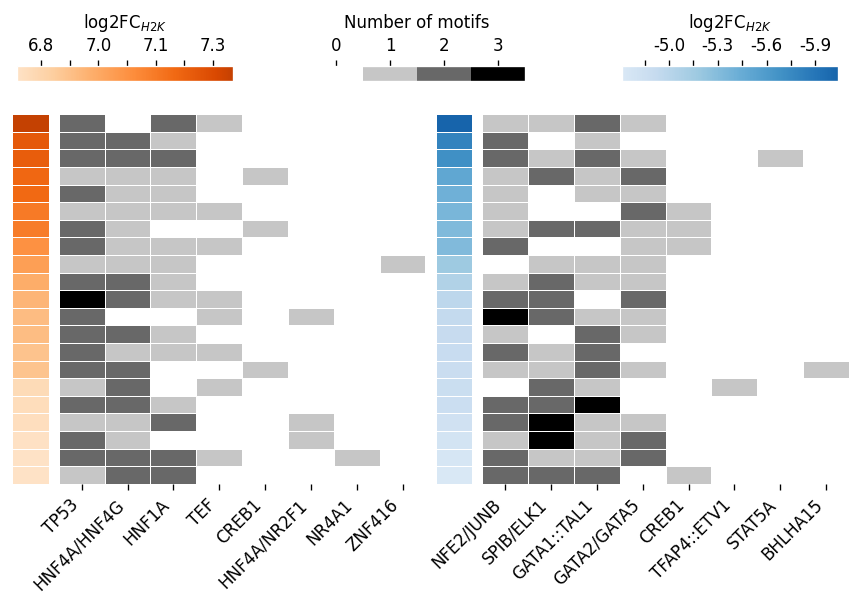

In [13]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle

bluesBig = matplotlib.cm.get_cmap('Blues', 512)
blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.15, 0.8, 256)))
# create reverse version of blues_trunc_cm
blues_trunc_cm_r = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.8, 0.15, 256)))

orangesBig = matplotlib.cm.get_cmap('Oranges', 512)
oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.15, 0.8, 256)))

# create new numpy array that's n_seqs x n_clusters
clusters = np.array([col for col in analysis_df.columns if col.startswith('cluster_')])
print(f'{len(clusters)} clusters')

hepg2_df = analysis_df[analysis_df['cell_type']=='HEPG2']
k562_df = analysis_df[analysis_df['cell_type']=='K562']
# sort hepg2_df in descending order of log2FoldChange_H2K_deseq
hepg2_df = hepg2_df.sort_values(by=H2K_COL,ascending=False)
# sort k562_df in ascending order of log2FoldChange_H2K_deseq
k562_df = k562_df.sort_values(by=H2K_COL,ascending=True)

hepg2_sort_inds = np.argsort(np.array(hepg2_df[clusters]).sum(axis=0))[::-1]
k562_sort_inds = np.argsort(np.array(k562_df[clusters]).sum(axis=0))[::-1]

###########################################################################################

# okay, this was sort of all right. maybe let's try looking at only the top 50% of sequences, and dropping any columns that are all 0s
# maybe want to replace percentile with single number so plot is more symmetric
percentile = 0.05

# get maximum of int(len(hepg2_df)*percentile) and int(len(k562_df)*percentile)
n_seqs = max(int(len(hepg2_df)*percentile),int(len(k562_df)*percentile))


hepg2_df_filt = hepg2_df.head(n_seqs)
k562_df_filt = k562_df.head(n_seqs)

hepg2_clusters = np.array([cluster for cluster in clusters if np.array(hepg2_df_filt[cluster]).sum()>0])
k562_clusters = np.array([cluster for cluster in clusters if np.array(k562_df_filt[cluster]).sum()>0])

print(f'HEPG2 clusters: {len(hepg2_clusters)}')
print(f'K562 clusters: {len(k562_clusters)}')

# okay let's redo those heatmaps now!

hepg2_max = hepg2_df_filt[hepg2_clusters].max().max()
k562_max = k562_df_filt[k562_clusters].max().max()

global_max = max(hepg2_max,k562_max)
print(global_max)

vmin = 0
# vmax = dw_deseq_plus_cluster_cnts_df['n_motifs'].max()
vmax = global_max

# make the cmap for heatmap
n_colors = int(vmax-vmin+1)
colors = plt.cm.Greys(np.linspace(0, 1, n_colors))
# colors = plt.cm.Greys(np.array([0,0.3,0.4,0.5,0.6,0.7]))
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_colors)

# set h2k_vmax to be the max abs H2K_COL between hepg2_df_filt and k562_df_filt
h2k_vmax = max(abs(hepg2_df_filt[H2K_COL]).max(),abs(k562_df_filt[H2K_COL]).max())
# set h2k_vmin to be min abs H2K_COL between hepg2_df_filt and k562_df_filt
h2k_vmin = min(abs(hepg2_df_filt[H2K_COL]).min(),abs(k562_df_filt[H2K_COL]).min())

# plot np.array(hepg2_df_filt[hepg2_clusters]) as heatmap with rows corresponding to sequences and columns the motifs
n_clusters_to_plot = 8
hepg2_filt_sort_inds = np.argsort(np.array(hepg2_df_filt[hepg2_clusters]).sum(axis=0))[::-1][:n_clusters_to_plot]
k562_filt_sort_inds = np.argsort(np.array(k562_df_filt[k562_clusters]).sum(axis=0))[::-1][:n_clusters_to_plot]

# set figure width based on number of clusters, using a constant width_per_cluster
width_per_cluster = 5
# fig_width = width_per_cluster * len(hepg2_clusters)
fig_width = width_per_cluster *(len(hepg2_clusters)+len(k562_clusters))

# make 2 side by side subplots
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4,figsize=(9,4),sharey=True,gridspec_kw={'width_ratios': [1,10,1,10]})
# plot hepg2 heatmap
sns.heatmap(np.array(hepg2_df_filt[hepg2_clusters])[:,hepg2_filt_sort_inds],xticklabels=hepg2_clusters[hepg2_filt_sort_inds],cmap=cmap,
            cbar=False,ax=ax1,vmin=vmin,vmax=vmax,edgecolor='white',linewidth=0.5)
# remove yticks
ax1.set_yticks([])
# ax1.set_title(f'HEPG2')
ax1.set_xticklabels([cluster_name_dict[cluster] for cluster in hepg2_clusters[hepg2_filt_sort_inds]],fontsize=TEXT_FSIZE,rotation=45,ha='right')
# plot hepg2 log2(H2K):
sns.heatmap(hepg2_df_filt[H2K_COL].values.reshape(-1, 1), cmap=oranges_trunc_cm, cbar=False, ax=ax0,annot=False,
            fmt='.1f',edgecolor='white',linewidth=0.5) #,vmin=h2k_vmin,vmax=h2k_vmax

# plot k562 heatmap
sns.heatmap(np.array(k562_df_filt[k562_clusters])[:,k562_filt_sort_inds],xticklabels=k562_clusters[k562_filt_sort_inds],cmap=cmap,
            cbar=False,ax=ax3,vmin=vmin,vmax=vmax,edgecolor='white',linewidth=0.5)
# remove yticks
ax3.set_yticks([])
# ax3.set_title(f'K562')
ax3.set_xticklabels([cluster_name_dict[cluster] for cluster in k562_clusters[k562_filt_sort_inds]],fontsize=TEXT_FSIZE,rotation=45,ha='right')
# plot k562 log2(H2K):
sns.heatmap(k562_df_filt[H2K_COL].values.reshape(-1, 1), cmap=blues_trunc_cm_r, cbar=False, ax=ax2,annot=False,
            fmt='.1f',edgecolor='white',linewidth=0.5) #,vmin=-h2k_vmax,vmax=-h2k_vmin

# set overall figure title
# fig.suptitle(f'Motifs in top {int(percentile*100)}% of sequences\n')

# add colorbar below the subplots
# cbar_ax = fig.add_axes([0.3, -0.175, 0.4, 0.03])
from matplotlib.ticker import MaxNLocator
cbar_ax = fig.add_axes([0.4, 0.95, 0.2, 0.03])

boundaries = np.linspace(vmin - 0.5, vmax + 0.5, n_colors + 1)
ticks = np.arange(vmin, vmax + 1)

cb = fig.colorbar(ax1.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=boundaries,ticks=ticks,format="%d")
# plt.colorbar(ticks=ticks, boundaries=boundaries, format="%d", orientation='vertical')
# cb = fig.colorbar(ax1.collections[0], cax=cbar_ax,orientation='horizontal',label='Number of motifs',shrink=0.01,drawedges=False,boundaries=np.arange(0,vmax+1,1),ticks=np.arange(0,vmax+1,1))
cbar_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
cbar_ax.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax.set_title('Number of motifs',fontsize=TEXT_FSIZE,y=3)
# remove x and y labels
cbar_ax.set_xlabel('')
cbar_ax.set_ylabel('')
# set cb outline to white
cb.outline.set_edgecolor('white')
# set cb ticks to ticks
cb.set_ticks(ticks=ticks,labels=np.arange(vmin,vmax+1).astype(int))


# add colorbar for H2K for HEPG2 seqs to the left of cbar_ax
cbar_ax_hepg2_h2k = fig.add_axes([0.13, 0.95, 0.2, 0.03])
cb_hepg2 = fig.colorbar(ax0.collections[0], cax=cbar_ax_hepg2_h2k,orientation='horizontal',label='log2(HEPG2/K562)',shrink=0.01,drawedges=False)
cbar_ax_hepg2_h2k.xaxis.set_major_locator(MaxNLocator(integer=True))
# move ticks above colorbar
cbar_ax_hepg2_h2k.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax_hepg2_h2k.set_title('log2FC$_{H2K}$',fontsize=TEXT_FSIZE,y=3)
# remove x and y labels
cbar_ax_hepg2_h2k.set_xlabel('')
cbar_ax_hepg2_h2k.set_ylabel('')
# set tick formating to .1f
cbar_ax_hepg2_h2k.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# set colorbar outline to white
cb_hepg2.outline.set_edgecolor('white')


# add colorbar for H2K for K562 seqs to the right of cbar_ax
cbar_ax_k562_h2k = fig.add_axes([0.69, 0.95, 0.2, 0.03])
cb_k562 = fig.colorbar(ax2.collections[0], cax=cbar_ax_k562_h2k,orientation='horizontal',label='log2(K562/HEPG2)',shrink=0.01,drawedges=False)
cbar_ax_k562_h2k.xaxis.set_major_locator(MaxNLocator(integer=True))
# move ticks above colorbar
cbar_ax_k562_h2k.xaxis.tick_top()
# move title of cbar_ax to above the colorbar
cbar_ax_k562_h2k.set_title('log2FC$_{H2K}$',fontsize=TEXT_FSIZE,y=3)
# remove x and y labels
cbar_ax_k562_h2k.set_xlabel('')
cbar_ax_k562_h2k.set_ylabel('')
# set tick formating to .1f
# impoer FormatStrFormatter from matplotlib.ticker
from matplotlib.ticker import FormatStrFormatter
cbar_ax_k562_h2k.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# reverse the order of the colorbar
cbar_ax_k562_h2k.invert_xaxis()
# set colorbar outline to white
cb_k562.outline.set_edgecolor('white')


# cbar = fig.colorbar(sns.heatmap(np.array(hepg2_df_filt[hepg2_clusters])[:,hepg2_filt_sort_inds],xticklabels=hepg2_clusters[hepg2_filt_sort_inds],cmap='bone_r',cbar=False,ax=ax1,vmin=vmin,vmax=vmax),cax=cbar_ax,orientation='horizontal')

# only show integer xticks on colorbar
# import MaxNLocator from matplotlib.ticker



# remove yticks from ax0 and ax2
ax0.set_yticks([])
ax2.set_yticks([])
# remove xticks from ax0 and ax2
ax0.set_xticks([])
ax2.set_xticks([])
# decrease space between ax0 and ax1
plt.subplots_adjust(wspace=0.05)

# plot every other xtick label on cbar_ax_hepg2_h2k
for i,tick in enumerate(cbar_ax_hepg2_h2k.get_xticklabels()):
    if i%2==0:
        tick.set_visible(False)

# plot every other xtick label on cbar_ax_k562_h2k
for i,tick in enumerate(cbar_ax_k562_h2k.get_xticklabels()):
    if i%2==0:
        tick.set_visible(False)


# save figure at 600 dpi
plt.savefig(f'{fig2_dir}/d3_top{int(percentile*100)}pct_motifs_heatmap.png',dpi=600,bbox_inches='tight')

plt.show()

### Fig 3I: Motif repeat boxplots ###

In [4]:
# motif repeat analysis
def extract_motif_repeats_by_id(seq_df,motif_df,motif_names,n_thresh=None,dw=False):
        # args should be 'h','k', and/or 'd' for HEPG2, K562, and H2K_deseq respectively

        seq_df = seq_df.copy()

        # if motif_names is not a list make it a list
        if type(motif_names) != list:
                motif_names = [motif_names]
        
        # create a new column in df that is the number of motif_names motifs in each sequence
        seq_df['n_cur_motif_repeats'] = 0
        # if not in dhs dataset, this is outdated
        if not dw:
                for seq_name in seq_df['sequence_name'].values:
                        if seq_name in motif_df['sequence_name'].values:
                                seq_df.loc[seq_df['sequence_name']==seq_name,f'n_cur_motif_repeats'] = motif_df[(motif_df['sequence_name']==seq_name) & (motif_df['motif_id'].isin(motif_names))].shape[0]
        else:
                for seq_name in seq_df['sequence_name']:
                        if seq_name in motif_df['sequence_name'].values:
                                seq_df.loc[seq_df['sequence_name']==seq_name,f'n_cur_motif_repeats'] = motif_df[(motif_df['sequence_name']==seq_name) & (motif_df['motif_id'].isin(motif_names))].shape[0]

        if n_thresh is not None:
                # combine all repeats above n_thresh
                seq_df.loc[seq_df['n_cur_motif_repeats']>=n_thresh,'n_cur_motif_repeats'] = n_thresh

        # get unique values of n_cur_motif_repeats
        # n_repeats = seq_df['n_cur_motif_repeats'].value_counts().index.sort_values()
        n_repeats = seq_df['n_cur_motif_repeats'].max()

        y_seqs_dict = {}
        y_cols = [HEPG2_COL,K562_COL,H2K_COL]

        for n_repeat in range(n_repeats+1):
                y_seqs_dict[f'{n_repeat}'] = np.array(seq_df[seq_df['n_cur_motif_repeats']==n_repeat][y_cols])
                        
                    
        return y_seqs_dict

def extract_motif_repeats(seq_df,motif_df,motif_names,n_thresh=None):
        # args should be 'h','k', and/or 'd' for HEPG2, K562, and H2K_deseq respectively

        seq_df = seq_df.copy()

        # if motif_names is not a list make it a list
        if type(motif_names) != list:
                motif_names = [motif_names]
        
        # create a new column in df that is the number of motif_names motifs in each sequence
        seq_df['n_cur_motif_repeats'] = 0
        for seq_idx in range(seq_df.shape[0]):
                if seq_idx in motif_df['sequence_name'].values:
                        seq_df.loc[seq_idx,f'n_cur_motif_repeats'] = motif_df[(motif_df['sequence_name']==seq_idx) & (motif_df['motif_alt_id'].isin(motif_names))].shape[0]

        if n_thresh is not None:
                # combine all repeats above n_thresh
                seq_df.loc[seq_df['n_cur_motif_repeats']>=n_thresh,'n_cur_motif_repeats'] = n_thresh

        # get unique values of n_cur_motif_repeats
        # n_repeats = seq_df['n_cur_motif_repeats'].value_counts().index.sort_values()
        n_repeats = seq_df['n_cur_motif_repeats'].max()

        y_seqs_dict = {}
        y_cols = [HEPG2_COL,K562_COL,H2K_COL]

        for n_repeat in range(n_repeats+1):
                y_seqs_dict[f'{n_repeat}'] = np.array(seq_df[seq_df['n_cur_motif_repeats']==n_repeat][y_cols])
                        
                    
        return y_seqs_dict

TEXT_FSIZE = 12
AXIS_FSIZE = 14


    # ahhh no I really need the cluster_50 not TP53 because otherwise there are some very highly valued 0 repeats
    # bonferroni correction

# this time use statannot to add significance bars
def plot_motif_repeats3(y_seqs_dict,title,n_thresh=True,alt='two-sided',title_size=16,axis_size=14,tick_size=14,figsize=(5,3),no_ylabel=False):
    # boxplot of predictions for each number of repeats - unregularized model
    n_repeats = int(list(y_seqs_dict.keys())[-1])
    labels = [f'{n_repeat}\n({y_seqs_dict[f"{n_repeat}"].shape[0]})' for n_repeat in range(n_repeats+1)]
    if n_thresh:
        labels[-1] = f'{n_repeats}+\n({y_seqs_dict[f"{n_repeats}"].shape[0]})'
#     plt.figure(figsize=figsize)
    fig,ax = plt.subplots(figsize=figsize)
    x = [y_seqs_dict[f'{n_repeat}'][:,0]-y_seqs_dict[f'{n_repeat}'][:,1] for n_repeat in range(n_repeats+1)]
#     plt.boxplot(x,labels=labels,positions=range(len(x)),
#                 flierprops=dict(markerfacecolor='k', marker='o', markersize=2, markeredgecolor='k'),zorder=20)
#     plt.xticks(fontsize=TEXT_FSIZE)
#     plt.yticks(fontsize=TEXT_FSIZE)

    # annotate significance with statannot
    # # turn y_seqs_dict into a dataframe where for each key, every value is a row with the key as a column
    plot_df = pd.DataFrame(columns=['x','y'])
    for key in y_seqs_dict.keys():
        cur_df = pd.DataFrame({'x':np.repeat(key,y_seqs_dict[key].shape[0]),'y':y_seqs_dict[key][:,-1]})
        plot_df = pd.concat([plot_df,cur_df],axis=0)

    plot_df['x'] = plot_df['x'].astype(str)
    sns.boxplot(x='x',y='y',data=plot_df,ax=ax,zorder=10,color='k',width=0.5,medianprops={"color": "orange"},
                boxprops={"edgecolor":"black","linewidth":1,"facecolor":'white'},whiskerprops={"color":"black","linewidth":1},
                flierprops=dict(markerfacecolor='k', marker='o', markersize=1, markeredgecolor='k'),
                capprops={'color':'black','linewidth':1})
    # seq xlabels
    ax.set_xticklabels(labels,fontsize=tick_size)
    plt.xticks(fontsize=TEXT_FSIZE)
    plt.yticks(fontsize=TEXT_FSIZE)
    # not statannot doesn't work with the most updated packages...so will have to create an environment to plot these eventually if I want auto annotations
#     statannot.add_stat_annotation(x='x',y='y',data=plot_df,ax=ax,
#                                   box_pairs=[('0','1'),('1','2'),('2','3')],
#                                   test='Mann-Whitney',text_format='star',loc='outside',verbose=2,comparisons_correction='bonferroni')


    # draw a line between the medians of each boxplot
    medians = [np.median(y_seqs_dict[f'{n_repeat}'][:,0]-y_seqs_dict[f'{n_repeat}'][:,1]) for n_repeat in range(n_repeats+1)]
    plt.plot(range(len(medians)),medians,'k--',zorder=20)
    print(medians)


    plt.xlabel(title,fontsize=AXIS_FSIZE)
    if no_ylabel:
        plt.ylabel('')
    else:   
        plt.ylabel('log2(HEPG2/K562)',fontsize=AXIS_FSIZE)
#     plt.title(title + '',fontsize=title_size)
    # remove spines
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # increase distance between yaxis label and yticks
    ax.xaxis.labelpad = 12
    ax.yaxis.labelpad = 12

    plt.grid(axis='y',color='gray',linestyle='--',linewidth=0.5,zorder=-20)
    
#     plt.show()

    # mann-whitney u test for 0 vs 1, 1 vs 2, 2 vs 3
    from scipy.stats import mannwhitneyu
    p_vec = []
    for n in range(n_repeats):
        u,p = mannwhitneyu(y_seqs_dict[f'{n+1}'][:,0]-y_seqs_dict[f'{n+1}'][:,1],y_seqs_dict[f'{n}'][:,0]-y_seqs_dict[f'{n}'][:,1],alternative=alt)
        print(f'{n} vs {n+1}: u={u}, p={p:.2e}')
        p_vec.append(p)

    padj = fdrcorrection(p_vec,alpha=0.05,method='indep',is_sorted=False)[1]
    print(padj)

    return fig,ax

In [5]:
model_types = ['d1_finetuned','d2_dhs','d2_meas','ablated','shuffled_nonmotif']
d3_seq_df[d3_seq_df['model_type'].isin(model_types)]['design_type'].value_counts()

design_type
fsp                             468
ablated                         331
fsp_clipped                     220
d2_rand_ctrl                    198
fsp_tgt                         160
motif_flank_opt                 128
fsp_minimal                     110
nonmotif_masked_fsp             100
fsp_minimal_concatemer           60
shuffled_nonmotif                49
fsp_max1                         20
fsp_min1                         20
fsp_clipped_max1                 20
fsp_clipped_min1                 19
fsp_minimal_cross_concatemer     13
d2_top_ctrl                      10
concatemer                        5
Name: count, dtype: int64

In [6]:
# model_types = ['d1_finetuned','d2_dhs','d2_meas','ablated','shuffled_nonmotif']
model_types = ['d1_finetuned','d2_dhs','d2_meas','ablated','shuffled_nonmotif']
design_types = ['fsp','fsp_clipped','fsp_tgt',]
analysis_df = d3_deseq_plus_cluster_cnts_df[d3_deseq_plus_cluster_cnts_df['model_type'].isin(model_types)].copy()


cluster_cols = [col for col in analysis_df.columns if col.startswith('cluster_')]

cluster_multiplicity = np.zeros((len(cluster_cols),4)) # 0, 1, 2, 3+
for cluster_idx,cluster_col in enumerate(cluster_cols):
    for n in range(3):
        cluster_multiplicity[cluster_idx,n] = analysis_df[analysis_df[cluster_col]==n].shape[0]
    cluster_multiplicity[cluster_idx,3] = analysis_df[analysis_df[cluster_col]>=3].shape[0]


In [7]:
cluster_multiplicity_df = pd.DataFrame(cluster_multiplicity,columns=['0','1','2','3+'])
# add column for cluster_name
cluster_multiplicity_df['cluster'] = cluster_cols
# cluster_multiplicity['cluster_name'] = [cluster_name_dict[cluster] for cluster in cluster_cols]
# move cluster and cluster_name columns to front
cluster_multiplicity_df = cluster_multiplicity_df[['cluster','0','1','2','3+']]

In [8]:
cluster_multiplicity_df[cluster_multiplicity_df['2']+cluster_multiplicity_df['3+']>50]

,cluster,0,1,2,3+
0,cluster_50,1258.0,311.0,274.0,88.0
6,cluster_2,1461.0,299.0,146.0,25.0
9,cluster_1,1289.0,290.0,250.0,102.0
11,cluster_9,1406.0,284.0,179.0,62.0
20,cluster_11,1493.0,277.0,138.0,23.0
21,cluster_120,1508.0,278.0,117.0,28.0


In [11]:
cluster_multiplicity.values

array([1508,  278,  117,   28], dtype=int64)

In [9]:
cur_analysis_df = analysis_df.copy()
# threshold all multiplicities to 3
multiplicity_thresh = 3
pthresh = 0.01
for cluster_col in cluster_cols:
    cur_analysis_df[cluster_col] = cur_analysis_df[cluster_col].apply(lambda x: multiplicity_thresh if x>=multiplicity_thresh else x)
for cluster_idx in [50,2,1,9,11,120]:
    # get multiplicity counts
    cluster_multiplicity = cur_analysis_df[f'cluster_{cluster_idx}'].value_counts().sort_index().values
    medians = [np.median(cur_analysis_df[cur_analysis_df[f'cluster_{cluster_idx}']==n][H2K_COL]) for n in range(multiplicity_thresh+1)]
    # wilcoxon rank sum between each consecutive pair of multiplicity
    p_vec = []
    for n in range(multiplicity_thresh):
        u,p = ranksums(cur_analysis_df[cur_analysis_df[f'cluster_{cluster_idx}']==n][H2K_COL],cur_analysis_df[cur_analysis_df[f'cluster_{cluster_idx}']==n+1][H2K_COL])
        p_vec.append(p)
        # print(f'\t{n} vs {n+1}: p={p:.2e}')

    print(f'Cluster {cluster_idx} / {cluster_name_dict[f"cluster_{cluster_idx}"]}')
    sig_str = ['']+['*' if p < pthresh else '' for p in p_vec]
    result_str = [f'{n}: {median:.2f} ({mult}){sig}' for n,median,mult,sig in zip(range(multiplicity_thresh+1),medians,cluster_multiplicity,sig_str)]
    # concatenate result_str and print
    print('\t',', '.join(result_str))



Cluster 50 / TP53
	 0: -1.95 (1258), 1: 4.86 (311)*, 2: 5.46 (274)*, 3: 5.67 (88)
Cluster 2 / HNF4A/HNF4G
	 0: -1.24 (1461), 1: 5.30 (299)*, 2: 5.69 (146)*, 3: 5.21 (25)
Cluster 1 / NFE2/JUNB
	 0: 3.19 (1289), 1: -2.49 (290)*, 2: -2.56 (250), 3: -1.93 (102)*
Cluster 9 / SPIB/ELK1
	 0: 2.27 (1406), 1: -1.95 (284)*, 2: -2.88 (179)*, 3: -2.95 (62)
Cluster 11 / GATA2/GATA5
	 0: 1.21 (1493), 1: -2.42 (277)*, 2: -1.58 (138)*, 3: -1.71 (23)
Cluster 120 / GATA1::TAL1
	 0: 1.31 (1508), 1: -2.78 (278)*, 2: -3.13 (117)*, 3: -4.14 (28)*


C:\Users\Chris\AppData\Local\Temp\ipykernel_32896\4231984127.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df,cur_df],axis=0)
C:\Users\Chris\AppData\Local\Temp\ipykernel_32896\4231984127.py:107: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels,fontsize=tick_size)


[-1.6911249724278181, 4.6669322515873075, 5.6245126935414245, 5.218837363124775]
0 vs 1: u=309914.0, p=9.65e-81
1 vs 2: u=42062.0, p=1.43e-09
2 vs 3: u=6534.0, p=2.74e-03
[2.89562018e-80 2.14184531e-09 2.74337808e-03]


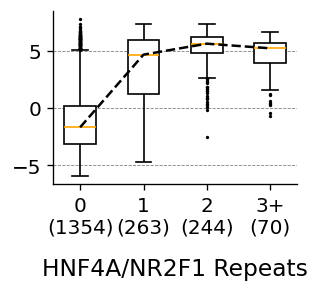

In [11]:
# motif_names = list(d2_final_df[(d2_final_df['jaspar_cluster']=='cluster_4')|(d2_final_df['jaspar_cluster']=='cluster_2')]['motif_id'].unique())
# [50,2,1,9,11,120]
for cluster_idx in [4]:
    motif_names = list(d3_final_df[d3_final_df['jaspar_cluster']==f'cluster_{cluster_idx}']['motif_id'].unique())
    # add to motif names also the motif_ids for cluster_2
    if cluster_idx == 4:
        motif_names = motif_names + list(d3_final_df[d3_final_df['jaspar_cluster']=='cluster_2']['motif_id'].unique())
    y_seqs_dict = extract_motif_repeats_by_id(analysis_df,d3_final_df,motif_names,n_thresh=3)
    title = f'{cluster_name_dict[f"cluster_{cluster_idx}"]} Repeats'
    # fig,ax=plot_motif_repeats2(y_seqs_dict,title,n_thresh=True,figsize=(3.5,2.5))
    fig,ax=plot_motif_repeats3(y_seqs_dict,title,n_thresh=True,figsize=(2.625,1.875),no_ylabel=True)
    plt.savefig(f'{figure_dir}/fig3f_{cluster_idx}_repeats_no_sig.png',dpi=500,bbox_inches='tight')

# save figure
# plt.savefig(f'figure_dir/general_exam_figs/fig3f_NFE2_JUNB_repeats.png',bbox_inches='tight',dpi=500)